In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [3]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve,confusion_matrix,classification_report
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.utils import to_categorical
%matplotlib inline
print('Librairies imported')

Importing librairies...


Using TensorFlow backend.


Librairies imported


In [4]:
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
df_1D = pd.read_csv('20190526 data prepared.csv')
df_1D = df_1D.iloc[:,1:]
df_1D = df_1D.dropna()
df_1D = df_1D.drop(['P/C Ratio'],axis=1)
df_1D.reset_index(inplace=True,drop=True)

In [6]:
df_1D.isnull().sum().sum()

0

In [7]:
df_1D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 27 columns):
Date                  1207 non-null int64
Vix                   1207 non-null float64
Varop_Spy             1207 non-null float64
Varhl_spy             1207 non-null float64
Varop_vix             1207 non-null float64
Varhl_vix             1207 non-null float64
RSI                   1207 non-null float64
75 - RSI              1207 non-null float64
RSI - 25              1207 non-null float64
BBD_Delta_Up          1207 non-null float64
delta5_8              1207 non-null float64
delta8_10             1207 non-null float64
delta10_12            1207 non-null float64
delta12_15            1207 non-null float64
delta15_30            1207 non-null float64
delta30_35            1207 non-null float64
delta35_40            1207 non-null float64
delta40_45            1207 non-null float64
delta45_50            1207 non-null float64
Spread                1207 non-null float64
Peaks          

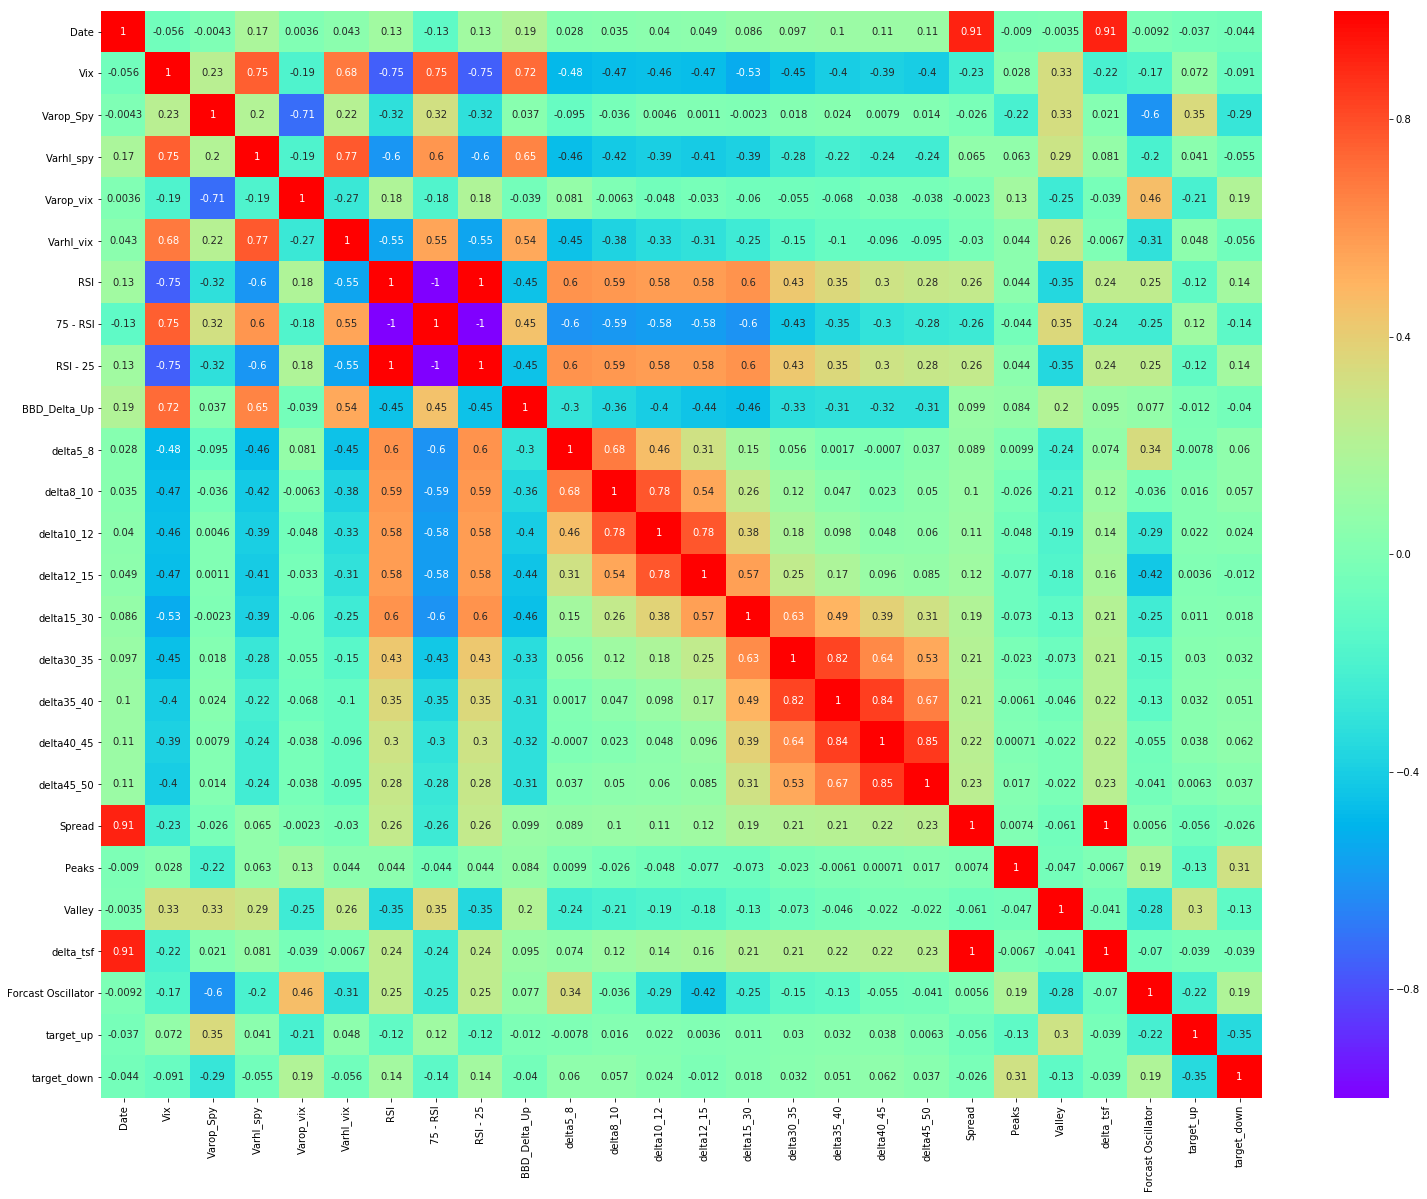

In [8]:
plt.figure(figsize=(26,20))
sns.heatmap(df_1D.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [9]:
df_1D.shape

(1207, 27)

In [10]:
df_1D['target_up'].sum(),df_1D['target_down'].sum()

(314, 311)

In [11]:
delta = round(df_1D.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_1D.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_1D.iloc[bloc2,0],')')
print('First period :',df_1D.iloc[0,0])
print('Last period :',df_1D.iloc[df_1D.shape[0]-1,0])


# of periods :  1207
On 80% - 20% slash : 
Bloc 1 :  966  periods ( 20180612 )
Bloc 2 : 241  periods ( 20150727 )
First period : 20140811
Last period : 20190528


In [12]:
X = df_1D.iloc[:,1:-4]
#X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['75 - RSI','RSI - 25'],axis=1)
y_up = df_1D.iloc[:,-3].values
y_down = df_1D.iloc[:,-2].values
X = X.drop(['Vix','Varop_vix','Varhl_vix'],axis=1)

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 19 columns):
Varop_Spy       1207 non-null float64
Varhl_spy       1207 non-null float64
RSI             1207 non-null float64
75 - RSI        1207 non-null float64
RSI - 25        1207 non-null float64
BBD_Delta_Up    1207 non-null float64
delta5_8        1207 non-null float64
delta8_10       1207 non-null float64
delta10_12      1207 non-null float64
delta12_15      1207 non-null float64
delta15_30      1207 non-null float64
delta30_35      1207 non-null float64
delta35_40      1207 non-null float64
delta40_45      1207 non-null float64
delta45_50      1207 non-null float64
Spread          1207 non-null float64
Peaks           1207 non-null int64
Valley          1207 non-null int64
delta_tsf       1207 non-null float64
dtypes: float64(17), int64(2)
memory usage: 179.2 KB


In [14]:
X.iloc[:5,[6,7]]

delta5_8  delta8_10
0  -2.96150   -8.66850
1  -0.63850   -4.66350
2   1.96125    0.36775
3   9.05950   -0.05950
4   9.39725    1.30575

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))
y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [16]:
X[:5,[6,7]]

array([[0.60214404, 0.43108638],
       [0.62709698, 0.50316056],
       [0.65502268, 0.59370318],
       [0.73126986, 0.58601437],
       [0.73489786, 0.61058348]])

In [17]:
Xtrain = X[:bloc1,:]
Xtest = X[bloc1:,:]
ytrain_up = y_up[:bloc1,:]
ytest_up = y_up[bloc1:,:]
ytrain_down = y_down[:bloc1,:]
ytest_down = y_down[bloc1:,:]

In [18]:
Xtrain.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((966, 19), (966, 1), (966, 1), (241, 1), (241, 1))

In [19]:
# fix random seed for reproducibility
seed = 770
np.random.seed(seed)

In [20]:
ytrain_up = ytrain_up.reshape(ytrain_up.shape[0],)
ytrain_down = ytrain_down.reshape(ytrain_down.shape[0],)

Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1])

model_up = Sequential()
# Add an input layer 
model_up.add(Dense(23, activation='relu'))
# Add one hidden layer 
model_up.add(Dense(50, activation='relu'))
# Add an output layer 
model_up.add(Dense(1, activation='sigmoid'))

model_down = Sequential()
# Add an input layer 
model_down.add(Dense(23, activation='relu'))
# Add one hidden layer 
model_down.add(Dense(50, activation='relu'))
# Add an output layer 
model_down.add(Dense(1, activation='sigmoid'))

In [21]:
print('Processing move_up')
model_up.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mse'])
                   
history_up = model_up.fit(Xtrain, ytrain_up,epochs=50, batch_size=32, verbose=0)

print('Processing move_down')
model_down.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mse'])
                   
history_down = model_down.fit(Xtrain, ytrain_down,epochs=50, batch_size=32, verbose=0)

print('Computing done')

Processing move_up
Processing move_down
Computing done


In [22]:
train_acc_up = model_up.evaluate(Xtrain, ytrain_up,verbose=1)
train_acc_down = model_down.evaluate(Xtrain, ytrain_down,verbose=1)
train_acc_up,train_acc_down

966/966 [==============================] - 0s 66us/step


([0.46371875891527525, 0.7712215319676923, 0.15446196761807546],
 [0.4772403583886954, 0.7712215319676923, 0.1579023675673003])

In [23]:
yhat_up = model_up.predict_classes(Xtest)
yhat_down = model_down.predict_classes(Xtest)

In [24]:
score_up = model_up.evaluate(Xtest, ytest_up,verbose=1)
score_down = model_down.evaluate(Xtest, ytest_down,verbose=1)
score_up,score_down

241/241 [==============================] - 0s 17us/step


([0.5163970295324365, 0.7759336104531506, 0.16897100438962834],
 [0.5201838496315034, 0.7966804994092442, 0.1630993042744047])

In [25]:
confusion_matrix(ytest_up, yhat_up),

(array([[180,   4],
        [ 50,   7]]),)

In [26]:
confusion_matrix(ytest_down, yhat_down)

array([[184,   5],
       [ 44,   8]])

In [27]:
predict_up = model_up.predict(Xtest)
predict_down = model_down.predict(Xtest)

In [28]:

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 


roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [29]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("ROC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

RESULTATS UP

Accuracy: 77.59%
Precision: 63.64%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 12.28%   => Positifs trouvés par Golem sur tous les positifs existants
ROC: 55.05% 
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       184
           1       0.64      0.12      0.21        57

   micro avg       0.78      0.78      0.78       241
   macro avg       0.71      0.55      0.54       241
weighted avg       0.75      0.78      0.71       241

[[180   4]
 [ 50   7]]
Matrice de confusion :


Vrais_estimés    Faux_estimés
vrais_réels  Vrais_positifs    Faux_négatif
Faux_réels    Faux_positifs  Vrais-négatifs

In [30]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("ROC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

RESULTATS DOWN

Accuracy: 79.67%
Precision: 61.54%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 15.38%   => Positifs trouvés par Golem sur tous les positifs existants
ROC: 56.37% 
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       189
           1       0.62      0.15      0.25        52

   micro avg       0.80      0.80      0.80       241
   macro avg       0.71      0.56      0.56       241
weighted avg       0.77      0.80      0.75       241

[[184   5]
 [ 44   8]]
Matrice de confusion :


Vrais_estimés    Faux_estimés
vrais_réels  Vrais_positifs    Faux_négatif
Faux_réels    Faux_positifs  Vrais-négatifs

In [31]:
len(df_1D)-(len(df_1D)-241)

241

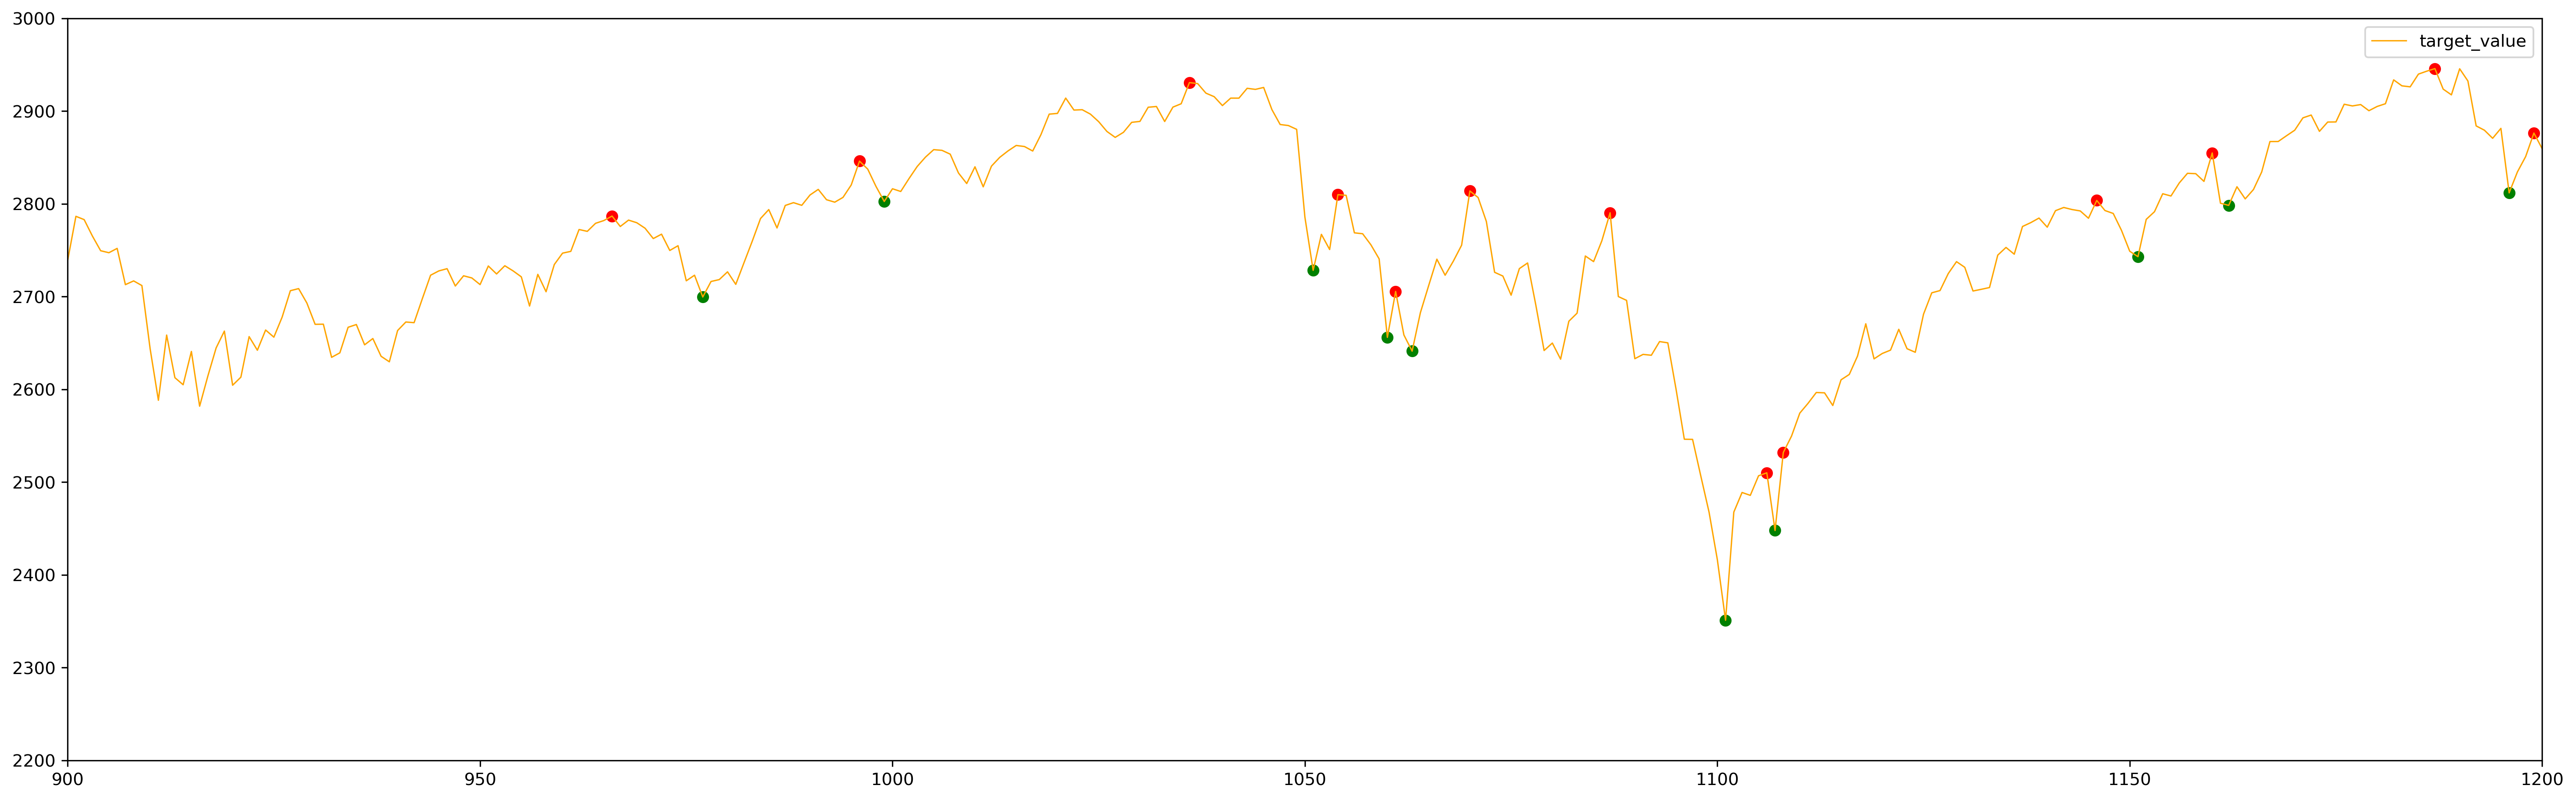

In [32]:
plt.figure(figsize=(26,8),dpi=300)
plt.plot(df_1D['target_value'],color='orange',lw=0.8)
plt.xlim(900,1200)
plt.ylim(2200,3000)
a = -1
for i in range(len(df_1D)-241,len(df_1D)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='r',marker='o')
plt.legend()

In [33]:
sum(yhat_up),sum(yhat_down)

(array([11], dtype=int32), array([13], dtype=int32))

In [34]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)